# Inference demo

## Setup

In [ ]:
%cd '/workspace/pytorch/MPA/'
import os
os.environ['CUDA_VISIBLE_DEVICES'] = str(0)


In [ ]:
import math
import io
import torch
from torchvision import transforms as T
import numpy as np

from PIL import Image

import matplotlib
import matplotlib.pyplot as plt

from pytorch_msssim import ms_ssim

from compressai.models import MPA
from compressai.zoo import load_state_dict

from ipywidgets import interact, widgets

# my_font = font_manager.FontProperties(fname='/usr/share/fonts/truetype/msttcorefonts/.ttf')
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = 'Arial_Bold'
font = {'family': 'serif', 'weight': 'normal', 'size': 12}
matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42 # 42 force to use Type 1 font (defaults to 3, i.e. Type 3 font)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
checkpoint_path = './checkpoints/pub/checkpoint_step3.pth.tar'

try:
    state_dict = load_state_dict(torch.load(checkpoint_path)['state_dict'])
except KeyError:
    state_dict = load_state_dict(torch.load(checkpoint_path))
# for key in state_dict.keys():
#     print(key, state_dict[key].size(0))
net = MPA.from_state_dict(state_dict).eval()
net = net.to(device)
net.update(force=True)

print(f'Parameters: {sum(p.numel() for p in net.parameters())}')


Parameters: 32124579


## Load image

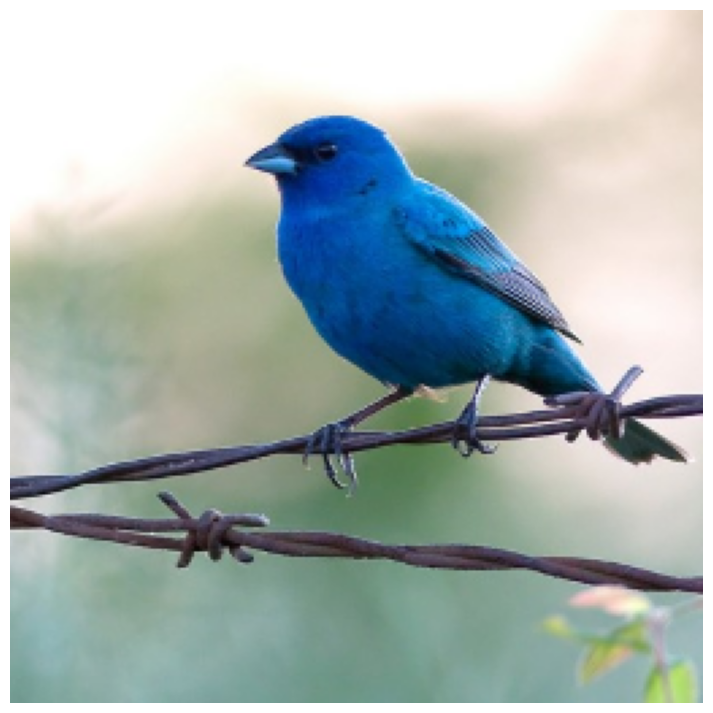

In [ ]:
# imnet_val_idx = '00022926'
imnet_val_idx = '00035565'
# imnet_val_idx = '00017577'
img = Image.open(f'./notebooks/assets/ILSVRC2012_val_{imnet_val_idx}.png').convert('RGB')
x = T.ToTensor()(img).unsqueeze(0).to(device)

%matplotlib inline
plt.figure(figsize=(12, 9))
plt.axis('off')
plt.imshow(img)
plt.show()


## Inference

In [4]:
from timm import create_model

# cls_model_name = "convnext_tiny_in22k"
cls_model_name = "convnext_tiny"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
# create a ConvNeXt model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/convnext.py
cls_model = create_model(cls_model_name, pretrained=True).to(device)


device =  cuda


In [5]:
# Define transforms for test
from timm.data.constants import \
    IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

NORMALIZE_MEAN = IMAGENET_DEFAULT_MEAN
NORMALIZE_STD = IMAGENET_DEFAULT_STD
SIZE = 256

# Here we resize smaller edge to 256, no center cropping
transforms = [
              T.Resize(SIZE, interpolation=T.InterpolationMode.BICUBIC),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

In [ ]:
import json
# imagenet_labels = json.load(open('./notebooks/label_to_words_in22k.json'))
imagenet_labels = json.load(open('./notebooks/label_to_words_in1k.json'))


In [7]:
def cal_psnr(a: torch.Tensor, b: torch.Tensor) -> float:
    psnr = []
    for i in range(len(a)):
        mse = torch.nn.functional.mse_loss(a[i], b[i]).item()
        psnr.append(-10 * math.log10(mse))
    return sum(psnr) / len(psnr)


Bit-rate:  0.0888671875bpp
MSE PSNR:  29.526171398735876dB
Perc PSNR: 28.69079538521155dB
Cls PSNR:  29.362642960456895dB


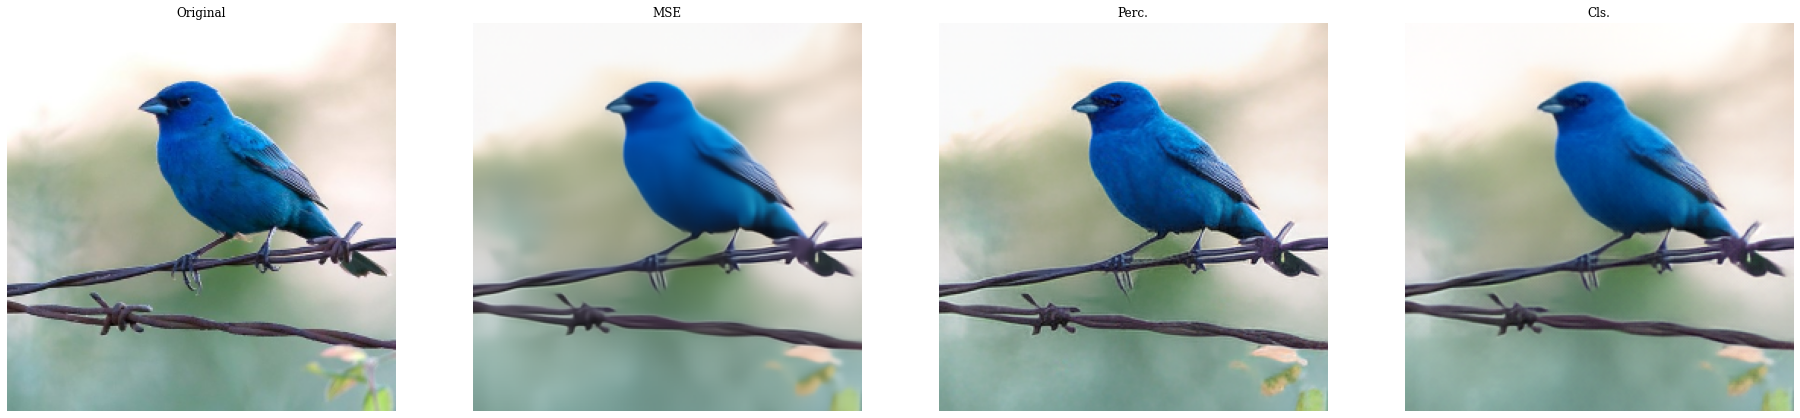

In [8]:
with torch.no_grad():
    out_enc = net.compress(x, quality=1)
num_pixels = x.size(0) * x.size(2) * x.size(3)
real_bpp = sum(sum(len(ss) for ss in s) for s in out_enc["strings"]) * 8.0 / num_pixels

with torch.no_grad():
    out_net = net.forward(x, quality=1, q_task=8, task_idx=0)
out_net['x_hat'].clamp_(0, 1)
rec_img_mse = T.ToPILImage()(out_net['x_hat'].squeeze().cpu())
rec_img_mse_psnr = cal_psnr(x, out_net['x_hat'])

with torch.no_grad():
    out_net = net.forward(x, quality=1, q_task=1, task_idx=1)
out_net['x_hat'].clamp_(0, 1)
rec_img_perc = T.ToPILImage()(out_net['x_hat'].squeeze().cpu())
rec_img_perc_psnr = cal_psnr(x, out_net['x_hat'])

with torch.no_grad():
    out_net = net.forward(x, quality=1, q_task=8, task_idx=1)
out_net['x_hat'].clamp_(0, 1)
rec_img_cls = T.ToPILImage()(out_net['x_hat'].squeeze().cpu())
rec_img_cls_psnr = cal_psnr(x, out_net['x_hat'])

%matplotlib inline
# fix, axes = plt.subplots(1, 2, figsize=(32, 24))
fix, axes = plt.subplots(1, 4, figsize=(32, 24))
for ax in axes:
    ax.axis('off')

print(f'Bit-rate:  {real_bpp}bpp')
print(f'MSE PSNR:  {rec_img_mse_psnr}dB')
print(f'Perc PSNR: {rec_img_perc_psnr}dB')
print(f'Cls PSNR:  {rec_img_cls_psnr}dB')

axes[0].imshow(img)
axes[0].title.set_text('Original')

axes[1].imshow(rec_img_mse)
axes[1].title.set_text('MSE')

axes[2].imshow(rec_img_perc)
axes[2].title.set_text('Perc.')

axes[3].imshow(rec_img_cls)
axes[3].title.set_text('Cls.')

plt.show()

os.makedirs(f'./figures/imagenet1k/val{imnet_val_idx}/', exist_ok=True)
img.save(f'./figures/imagenet1k/val{imnet_val_idx}/val{imnet_val_idx}_original.png')
rec_img_mse.save(f'./figures/imagenet1k/val{imnet_val_idx}/val{imnet_val_idx}_mse.png')
rec_img_perc.save(f'./figures/imagenet1k/val{imnet_val_idx}/val{imnet_val_idx}_perc.png')
rec_img_cls.save(f'./figures/imagenet1k/val{imnet_val_idx}/val{imnet_val_idx}_cls.png')


## Visualize Feature Map

In [ ]:
# define a hook to capture feature map
class FeatureMapHook:
    def __init__(self):
        self.feature_maps = []

    def __call__(self, module, input, output):
        self.feature_maps.append(output)


torch.Size([128, 128, 1])
torch.Size([64, 64, 1])
torch.Size([32, 32, 1])


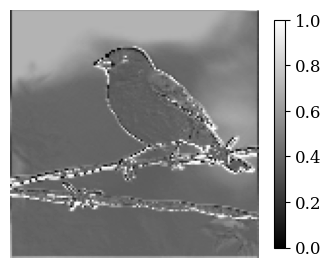

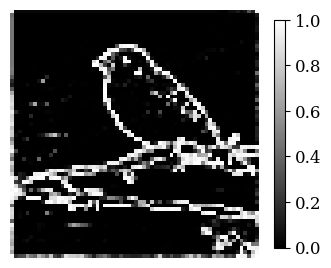

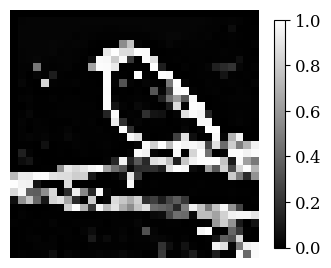

In [ ]:
target_layer_index = [1, 3, 5]

for i, stage in enumerate(target_layer_index):
    target_layer = eval(f'net.g_a{stage}.residual_group.score_predictor[0].out_conv[-1]')

    # create hook
    hook = FeatureMapHook()

    # register hook
    hook_handle = target_layer.register_forward_hook(hook)

    with torch.no_grad():
        net(x, quality=1, q_task=1, task_idx=0)
    print(hook.feature_maps[0][0].shape)
    predictor_enc = hook.feature_maps[0][0].sigmoid().squeeze(0).detach().cpu().numpy()

    # remove hook
    hook_handle.remove()

    %matplotlib inline
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.axis('off')

    im_predictor_enc = ax.imshow(predictor_enc, cmap='gray', vmin=0, vmax=1)
    # ax.title.set_text(f'Predictor in Encoder (Stage {3-i})')

    fig.colorbar(im_predictor_enc, ax=ax, shrink=0.74)
    fig.show()

    fig.savefig(f'./figures/imagenet1k/val{imnet_val_idx}/val{imnet_val_idx}_predictor_enc_g_a{stage}.pdf', bbox_inches='tight', pad_inches=0.0)


torch.Size([32, 32, 1])
torch.Size([64, 64, 1])
torch.Size([128, 128, 1])


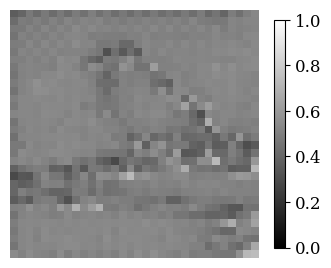

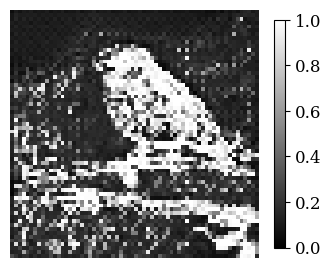

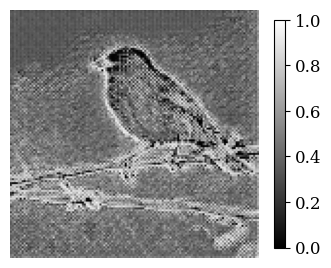

In [ ]:
target_layer_index = [2, 4, 6]

for i, stage in enumerate(target_layer_index):
    target_layer = eval(f'net.g_s{stage}.residual_group.score_predictor[0][0].out_conv[-1]')

    # create hook
    hook = FeatureMapHook()

    # register hook
    hook_handle = target_layer.register_forward_hook(hook)

    with torch.no_grad():
        net(x, quality=1, q_task=1, task_idx=0)
    print(hook.feature_maps[0][0].shape)
    predictor_mse = 1 - hook.feature_maps[0][0].sigmoid().squeeze(0).detach().cpu().numpy() # for better visualization

    # remove hook
    hook_handle.remove()

    %matplotlib inline
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.axis('off')

    im_predictor_mse = ax.imshow(predictor_mse, cmap='gray', vmin=0, vmax=1)
    # ax.title.set_text(f'Predictor in MSE Path (Stage {3-i})')

    fig.colorbar(im_predictor_mse, ax=ax, shrink=0.74)
    fig.show()

    fig.savefig(f'./figures/imagenet1k/val{imnet_val_idx}/val{imnet_val_idx}_predictor_mse_g_s{stage}.pdf', bbox_inches='tight', pad_inches=0.0)


torch.Size([32, 32, 1])
torch.Size([64, 64, 1])
torch.Size([128, 128, 1])


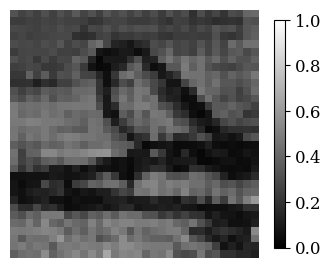

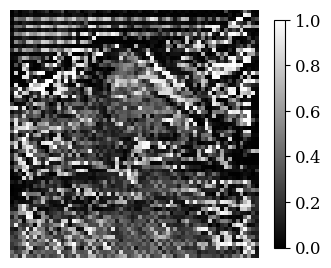

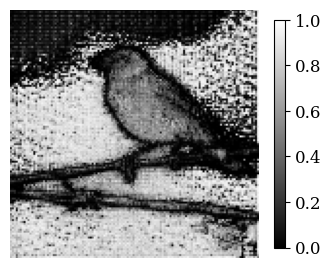

In [ ]:
target_layer_index = [2, 4, 6]

for i, stage in enumerate(target_layer_index):
    target_layer = eval(f'net.g_s{stage}.residual_group.score_predictor[1][0].out_conv[-1]')

    # create hook
    hook = FeatureMapHook()

    # register hook
    hook_handle = target_layer.register_forward_hook(hook)

    with torch.no_grad():
        net(x, quality=1, q_task=1, task_idx=1)
    print(hook.feature_maps[0][0].shape)
    predictor_cls = 1 - hook.feature_maps[0][0].sigmoid().squeeze(0).detach().cpu().numpy() # for better visualization

    # remove hook
    hook_handle.remove()

    %matplotlib inline
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.axis('off')

    im_predictor_cls = ax.imshow(predictor_cls, cmap='gray', vmin=0, vmax=1)
    # ax.title.set_text(f'Predictor in Cls. Path (Stage {3-i})')

    fig.colorbar(im_predictor_cls, ax=ax, shrink=0.74)
    fig.show()

    fig.savefig(f'./figures/imagenet1k/val{imnet_val_idx}/val{imnet_val_idx}_predictor_cls_g_s{stage}.pdf', bbox_inches='tight', pad_inches=0.0)


ConvNeXtBlock(
  (conv_dw): Conv2d(768, 768, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=768)
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=768, out_features=3072, bias=True)
    (act): GELU()
    (drop1): Dropout(p=0.0, inplace=False)
    (fc2): Linear(in_features=3072, out_features=768, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
  (drop_path): Identity()
)


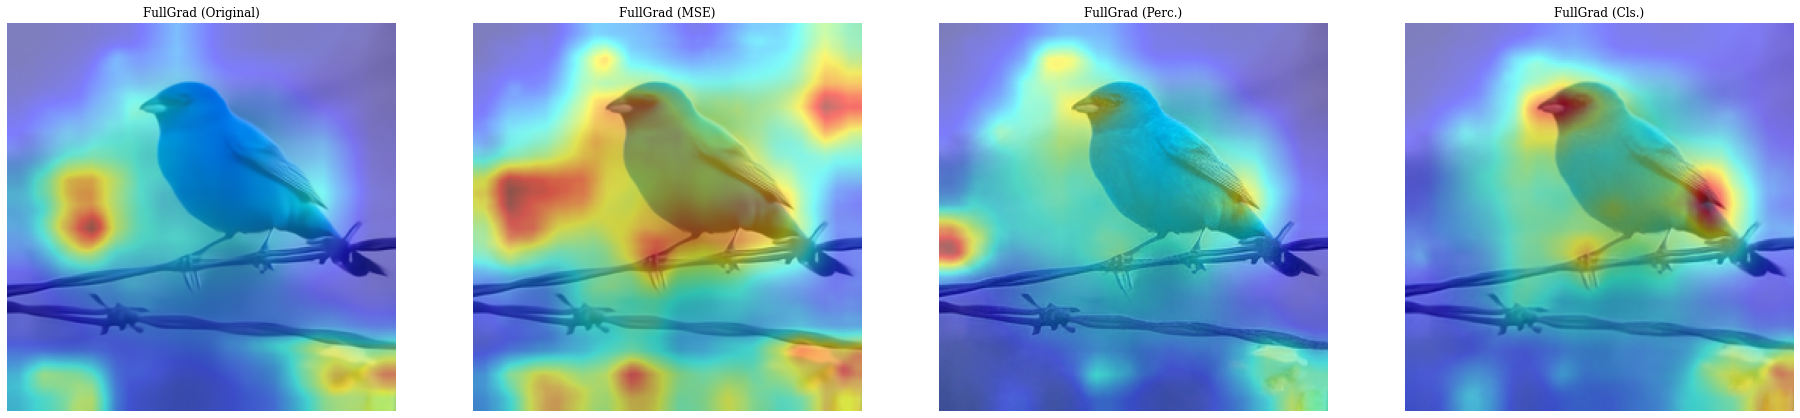

In [14]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

print(cls_model.stages[-1].blocks[-1])
target_layers = [cls_model.stages[-1].blocks[-1]]
cam = FullGrad(model=cls_model, target_layers=target_layers)
# targets = [ClassifierOutputTarget(137)]  # n02018207, American coot
targets = [ClassifierOutputTarget(14)]   # n01537544, indigo bunting
# targets = [ClassifierOutputTarget(12)]   # n01532829, house finch, linnet, Carpodacus mexicanus

img_tensor = transforms(img).unsqueeze(0).to(device)
grayscale_cam = cam(input_tensor=img_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
# mse_grayscale_cam = np.log2(1 + mse_grayscale_cam)
visualization = show_cam_on_image(T.ToTensor()(rec_img_mse).permute(1, 2, 0).numpy(), grayscale_cam, use_rgb=True)
# plt.imshow(visualization)
visualization = T.ToPILImage()(visualization)
visualization.save(f'./figures/imagenet1k/val{imnet_val_idx}/val{imnet_val_idx}_original_grad_cam.png')

mse_img_tensor = transforms(rec_img_mse).unsqueeze(0).to(device)
mse_grayscale_cam = cam(input_tensor=mse_img_tensor, targets=targets)
mse_grayscale_cam = mse_grayscale_cam[0, :]
# mse_grayscale_cam = np.log2(1 + mse_grayscale_cam)
mse_visualization = show_cam_on_image(T.ToTensor()(rec_img_mse).permute(1, 2, 0).numpy(), mse_grayscale_cam, use_rgb=True)
# plt.imshow(mse_visualization)
mse_visualization = T.ToPILImage()(mse_visualization)
mse_visualization.save(f'./figures/imagenet1k/val{imnet_val_idx}/val{imnet_val_idx}_mse_grad_cam.png')

perc_img_tensor = transforms(rec_img_perc).unsqueeze(0).to(device)
perc_grayscale_cam = cam(input_tensor=perc_img_tensor, targets=targets)
perc_grayscale_cam = perc_grayscale_cam[0, :]
# perc_grayscale_cam = np.log2(1 + perc_grayscale_cam)
perc_visualization = show_cam_on_image(T.ToTensor()(rec_img_perc).permute(1, 2, 0).numpy(), perc_grayscale_cam, use_rgb=True)
# plt.imshow(perc_visualization)
# print(perc_grayscale_cam)
perc_visualization = T.ToPILImage()(perc_visualization)
perc_visualization.save(f'./figures/imagenet1k/val{imnet_val_idx}/val{imnet_val_idx}_perc_grad_cam.png')

cls_img_tensor = transforms(rec_img_cls).unsqueeze(0).to(device)
cls_grayscale_cam = cam(input_tensor=cls_img_tensor, targets=targets)
cls_grayscale_cam = cls_grayscale_cam[0, :]
# cls_grayscale_cam = np.log2(1 + cls_grayscale_cam)
cls_visualization = show_cam_on_image(T.ToTensor()(rec_img_cls).permute(1, 2, 0).numpy(), cls_grayscale_cam, use_rgb=True)
# plt.imshow(cls_visualization)
# print(cls_grayscale_cam)
cls_visualization = T.ToPILImage()(cls_visualization)
cls_visualization.save(f'./figures/imagenet1k/val{imnet_val_idx}/val{imnet_val_idx}_cls_grad_cam.png')

# diff_grayscale_cam = perc_grayscale_cam - mse_grayscale_cam
# diff_visualization = show_cam_on_image(x[0].permute(1, 2, 0).cpu().numpy(), diff_grayscale_cam, use_rgb=True)
# plt.imshow(diff_visualization)
# diff_visualization = T.ToPILImage()(diff_visualization)
# diff_visualization.save(f'./figures/diff_grad_cam.png')

%matplotlib inline
# fix, axes = plt.subplots(1, 2, figsize=(32, 24))
fix, axes = plt.subplots(1, 4, figsize=(32, 24))
for ax in axes:
    ax.axis('off')

axes[0].imshow(visualization)
axes[0].title.set_text('FullGrad (Original)')

axes[1].imshow(mse_visualization)
axes[1].title.set_text('FullGrad (MSE)')

axes[2].imshow(perc_visualization)
axes[2].title.set_text('FullGrad (Perc.)')

axes[3].imshow(cls_visualization)
axes[3].title.set_text('FullGrad (Cls.)')

plt.show()


In [15]:
# inference
img_tensor = transforms(img).unsqueeze(0).to(device)
output = torch.softmax(cls_model(img_tensor), dim=1)
top5 = torch.topk(output, k=5)
top5_prob = top5.values[0]
top5_indices = top5.indices[0]

print("Original:")
for i in range(5):
    labels = imagenet_labels[str(int(top5_indices[i]))]
    prob = "{:.2f}%".format(float(top5_prob[i])*100)
    print(labels, prob)

img_tensor = transforms(rec_img_mse).unsqueeze(0).to(device)
output = torch.softmax(cls_model(img_tensor), dim=1)
top5 = torch.topk(output, k=5)
top5_prob = top5.values[0]
top5_indices = top5.indices[0]

print("\nMSE:")
for i in range(5):
    labels = imagenet_labels[str(int(top5_indices[i]))]
    prob = "{:.2f}%".format(float(top5_prob[i])*100)
    print(labels, prob)

img_tensor = transforms(rec_img_perc).unsqueeze(0).to(device)
output = torch.softmax(cls_model(img_tensor), dim=1)
top5 = torch.topk(output, k=5)
top5_prob = top5.values[0]
top5_indices = top5.indices[0]

print("\nPerc.:")
for i in range(5):
    labels = imagenet_labels[str(int(top5_indices[i]))]
    prob = "{:.2f}%".format(float(top5_prob[i])*100)
    print(labels, prob)

img_tensor = transforms(rec_img_cls).unsqueeze(0).to(device)
output = torch.softmax(cls_model(img_tensor), dim=1)
top5 = torch.topk(output, k=5)
top5_prob = top5.values[0]
top5_indices = top5.indices[0]

print("\nCls.:")
for i in range(5):
    labels = imagenet_labels[str(int(top5_indices[i]))]
    prob = "{:.2f}%".format(float(top5_prob[i])*100)
    print(labels, prob)


Original:
indigo bunting, indigo finch, indigo bird, Passerina cyanea 77.18%
black grouse 0.07%
dingo, warrigal, warragal, Canis dingo 0.06%
safety pin 0.06%
eft 0.06%

MSE:
indigo bunting, indigo finch, indigo bird, Passerina cyanea 32.92%
milk can 4.50%
whiskey jug 3.50%
Japanese spaniel 1.06%
Dandie Dinmont, Dandie Dinmont terrier 0.98%

Perc.:
indigo bunting, indigo finch, indigo bird, Passerina cyanea 76.57%
jay 0.13%
house finch, linnet, Carpodacus mexicanus 0.08%
rapeseed 0.08%
water ouzel, dipper 0.07%

Cls.:
indigo bunting, indigo finch, indigo bird, Passerina cyanea 81.64%
safety pin 0.06%
peacock 0.05%
European gallinule, Porphyrio porphyrio 0.05%
jay 0.05%
